# RESTify Controled Experiment Data Analysis

Mining data gathered during the [RESTify Experiment](https://www.cs.mcgill.ca/~mschie3/recruitment/) for correlations and insights.

## Step 1 - Representative population and fair group partition

Even before we begin extracting any insights from collected observations, we demonstrate that out test population was representative. Likewise we demonstrate how the generated partition forms comparable control groups.

### Test population

We recruited 28 software engineers from various backgrounds and diverse preliminary skills regarding the experiment tasks. In a preliminary recruitment procedure participants were [asked to provide a self evaluation of their skills](https://www.cs.mcgill.ca/~mschie3/recruitment/self-assessment.txt), where 1 signifies no and 5 signifies expert knowledge.  

#### Diversity

We started with a preliminary analysis of the competence diversity, reflected by out test population. We therefore computed the gaussian distribution for every skill, across the entire population.  
The outcome is depicted below:  


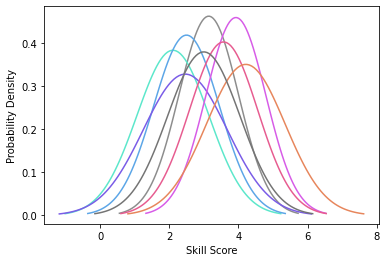

In [2]:
"""
This module reads participant skills from the participantskills.csv file, computes the gaussian
distributions per skill and creates a plot. The output file is stores in:
"generated-plots/gaussion.png"
"""
import csv

from restify_mining import participant_stat_tools
from restify_mining import skills
from restify_mining.participant import Participant
from restify_mining.plotter import plot_gaussian

# Load all participant skill objects from csv file
participants = []
with open('source-csv-files/partitionskills.csv', 'r', encoding="utf-8") as f:
    reader = csv.reader(f)
    # Flag to skip first line which is only the CSV column markers
    FIRST = True
    for row in reader:
        if FIRST:
            FIRST = False
        else:
            participants.append(Participant(row[0], [int(x) for x in row[1:]]))

# Compute a gaussian distribution (defined by mean and standard dev) for every skill and produce
# plot
skill_amount = len(participants[0].skills)
mean_scores = participant_stat_tools.build_mean_skills(participants)
stddev_scores = participant_stat_tools.build_standard_deviation_skills(participants)

# Plot gaussian curves for all participant skills
for index in range(skill_amount):
    plot_gaussian(mean_scores[index], stddev_scores[index], skills.palette[index])




The above densities can be considered sufficiently diverse for the purpose of our study. Although the population showcases varying average skill scores, the population likewise showcases a substantial score diversity for every skill observed. Yet we are acknowledge that the above data stems from subjective self-evaluations and is not necessarily a ground truth indicator for the population's actual skill diversity.

### Control groups

Goal of the experiment is the comparison of refactoring methodologies. To eliminate learning effects we asked participants to apply the two methodologies on different applications. Eliminating potential bias by task and application order resulted in a participant repartition into four control groups.

#### Heuristic Search for MiniMax
We ran a heuristic balancing algorithm to obtain control groups with high comparability in regards to their average score per skill. The algorithm searched for the participant distribution with lowest difference in skill differences per pair of team. Specifically, on every iteration we used the highest score difference on the same skill for any pair of control groups as quality metric. The original partitions were highly comparable: For every tested partition, we computed the highest difference for skill scores between any pair of teams. Goal was to minimize the value as far as possible, resulting in control groups that are highly comparable in any skill. We called this goal the search for the *MiniMax*. The value obtained through our heuristic for the originally recruited population was as low as ```0.6```, that means no matter what skill and pair of groups compared, the average difference in skill was guaranteed to be equal or lower to ```0.6```.

#### Droppers
Unfortunately participants dropped out, even after having committed to a task. At this point we were able to hire replacements, however it was impossible to re-generate a fully optimized new control group repartition. At this point we had already received the first test results and since due to learning effects the study can not be run twice by the same participant, we had to reduce optimizations to a brute force testing of all permutations of dropped out participants and potential replacements. This adjustment had to be repeated three times, since participants kept dropping out, even after deadline extensions and reassured intent of participation.  
Yet finally we were able to conclude the study with a population of 28 participants. Although comparability is not as optimal as in the original distribution, we were lucky enough to have ended up with somewhat comparable control groups.

The full boxplot of skill distributions per control group and resulting MiniMax (grid, printed in bold) is generated below:

In [7]:
print("le boxplot goes here")

le boxplot goes here


In [ ]:
print("le resulting stats grid and highight of resulting minimax, 1.43")

## Step 2 - Fusing the data

Throughout the experiment we measured different metrics per participant. Those are stored in separate CSV files. Some of them were auto-generated by additional scripts, some were created by hand.  
In a first step we are going to fuse all individual CSV files, using the *participant codename* as key. The codename consists of a colour and an animal.

 > We used a total of 4 control groups, *Red*, *Green*, *Blue*, *Yellow*, each starring 7 participants. This setup was chosen to reduce learning effects.
 
 The outcome of below cell is a new file: ```restify.csv```.  
 This file lists all data we ever process in the following, indexed by *participant codename*.

In [8]:
import pandas as pd

# Merge the individual key files. Use participant code name as key.
statscsv=pd.read_csv("source-csv-files/stats.csv")
taskcsv=pd.read_csv("source-csv-files/tasks.csv")
skillcsv=pd.read_csv("source-csv-files/partitionskills.csv")
intermediate1=statscsv.merge(taskcsv,on="codename")
result=intermediate1.merge(skillcsv,on="codename")
result.to_csv("restify.csv", index=None)

# Print the result
restifycsv = open("restify.csv", "r").read()
print(restifycsv)

codename,manualstatus,manualsuccessrate,assistedstatus,assistedsuccessrate,firstapproach,secondapproach,firstapp,secondapp,javaskill,springskill,mavenskill,touchcoreskill,unixskill,restskill,singletonskill,reflectionskill
Blue-Fox,OK,8-8,OK,8-12,touchcore,manual,xox,bookstore,2,1,2,4,5,3,5,4
Blue-Raccoon,OK,8-8,OK,7-12,touchcore,manual,xox,bookstore,3,1,2,2,4,3,5,1
Blue-Turtle,OK,3-8,NR,0,touchcore,manual,xox,bookstore,4,3,4,4,5,4,5,4
Blue-Unicorn,OK,8-8,OK,5-12,touchcore,manual,xox,bookstore,4,3,3,2,4,4,5,2
Blue-Zebra,OK,8-8,OK,7-12,touchcore,manual,xox,bookstore,3,1,2,3,2,4,5,4
Green-Fox,OK,7-8,NR,0,manual,touchcore,bookstore,xox,3,3,2,2,4,4,3,4
Green-Koala,OK,8-8,OK,7-12,manual,touchcore,bookstore,xox,4,2,3,5,5,4,5,4
Green-Raccoon,OK,6-8,OK,6-12,manual,touchcore,bookstore,xox,2,2,1,1,2,5,5,4
Green-Squid,OK,8-8,NR,0,manual,touchcore,bookstore,xox,3,2,2,3,3,3,2,1
Green-Turtle,OK,8-8,NR,0,manual,touchcore,bookstore,xox,3,3,3,4,4,4,3,3
Green-Unicorn,OK,8-8,NR,0,manual,touchcore,bookstor